In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "COMPSCI 682/compsci-682-project"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/COMPSCI 682/compsci-682-project


In [36]:
# Setting up imports
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import numpy as np
import soundfile as sf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import matplotlib.pyplot as plt

import torchvision

import torchaudio.datasets as audio_dset
import torchaudio.transforms as T

import librosa as lb

%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [4]:
class_labels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
num_classes = len(class_labels)

class ImageFeatureDataset(Dataset):
  def __init__(self, root, folder_in_archive: str = "images/mel_spectrogram"):
    self.root = root
    self._walker = []
    self._path = os.path.join(root, folder_in_archive)
    if not os.path.isdir(self._path):
      raise RuntimeError("Dataset not found. Please recheck the folder.")
    root = os.path.expanduser(self._path)
    for directory in class_labels:
      fulldir = os.path.join(root, directory)
      if not os.path.exists(fulldir):
        continue
      images_in_genre = os.listdir(fulldir)
      for fname in sorted(images_in_genre):
        name, ext = os.path.splitext(fname)
        if ext.lower() == ".png":
          genre, num = name[:-5], name[-5:]
          if genre in class_labels and len(num) == 5 and num.isdigit():
              self._walker.append(name)

  def __getitem__(self, n: int):
    fileid = self._walker[n]
    genre, _ = fileid.split(".")
    img = torchvision.io.read_image(os.path.join(self._path, genre, fileid + ".png"))
    return img, genre

  def get_names(self):
    print(self._walker)

  def __len__(self):
    return len(self._walker)

In [5]:
# Note that one song in GTZAN dataset contains data in unknown/corrupt format: we will delete if this exists.
if os.path.exists("datasets/genres/jazz/jazz.00054.wav"):
  os.remove("datasets/genres/jazz/jazz.00054.wav")

# Load the datasets (audio WAVs and image PNGs)
audio_dataset = audio_dset.GTZAN("datasets/")
melspectrogram_dataset = ImageFeatureDataset("datasets/", folder_in_archive="images/mel_spectrogram")

# Log details about the datasets
print("Number of audio instances: ", len(audio_dataset)) # Expect 999
print("Number of melspectrogram instances: ", len(melspectrogram_dataset)) # Expect 999
print("Number of class labels: ", num_classes) # Expect 10
print("Class labels: ", class_labels)

Number of audio instances:  999
Number of melspectrogram instances:  999
Number of class labels:  10
Class labels:  ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [6]:
# Definition of Helper Methods #

def print_stats(audio_data):
  waveform, sample_rate, label = audio_data
  print("-" * 10)
  print("Label:", label)
  print("-" * 10)
  print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3e}")
  print(f" - Min:     {waveform.min().item():6.3e}")
  print(f" - Mean:    {waveform.mean().item():6.3e}")
  print(f" - Std Dev: {waveform.std().item():6.3e}")
  print(waveform)

def plot_waveform(audio_data, title=None, ax=None):
    waveform, sample_rate, label = audio_data
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    if title is not None:
      ax.set_title(title)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])


def plot_spectrogram(audio_data, type="spectrogram", title=None, ax=None):
    waveform, sample_rate, label = audio_data
    if type == "melspectrogram":
      specgram = T.MelSpectrogram(sample_rate=sample_rate, n_mels=64)(waveform)[0]
    elif type == "mfcc":
      specgram = T.MFCC(sample_rate=sample_rate)(waveform)[0]
    else:
      specgram = T.Spectrogram()(waveform)[0]
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel("Frequency Bins" if type != "melspectrogram" else "Mel Frequency")
    ax.imshow(lb.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

# What does this mean? 661794 = 30 seconds * 22050 sample rate (bitrate)

# What does each number in the tensor mean?
The numbers in a PyTorch waveform represent the amplitude of the waveform at each point in time. The waveform is a sequence of numbers, where each number represents the amplitude of the waveform at a specific point in time. The waveform is typically used to represent audio signals, but it can also be used to represent other types of signals, such as video signals or sensor data.

# What is the minimum-maximum range for each value in the tensor?


----------
Label: blues
----------
Sample Rate: 22050
Shape: (1, 661794)
Dtype: torch.float32
 - Max:     8.854e-01
 - Min:     -8.402e-01
 - Mean:    -5.968e-05
 - Std Dev: 1.407e-01
tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.0556, -0.0611, -0.0642]])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


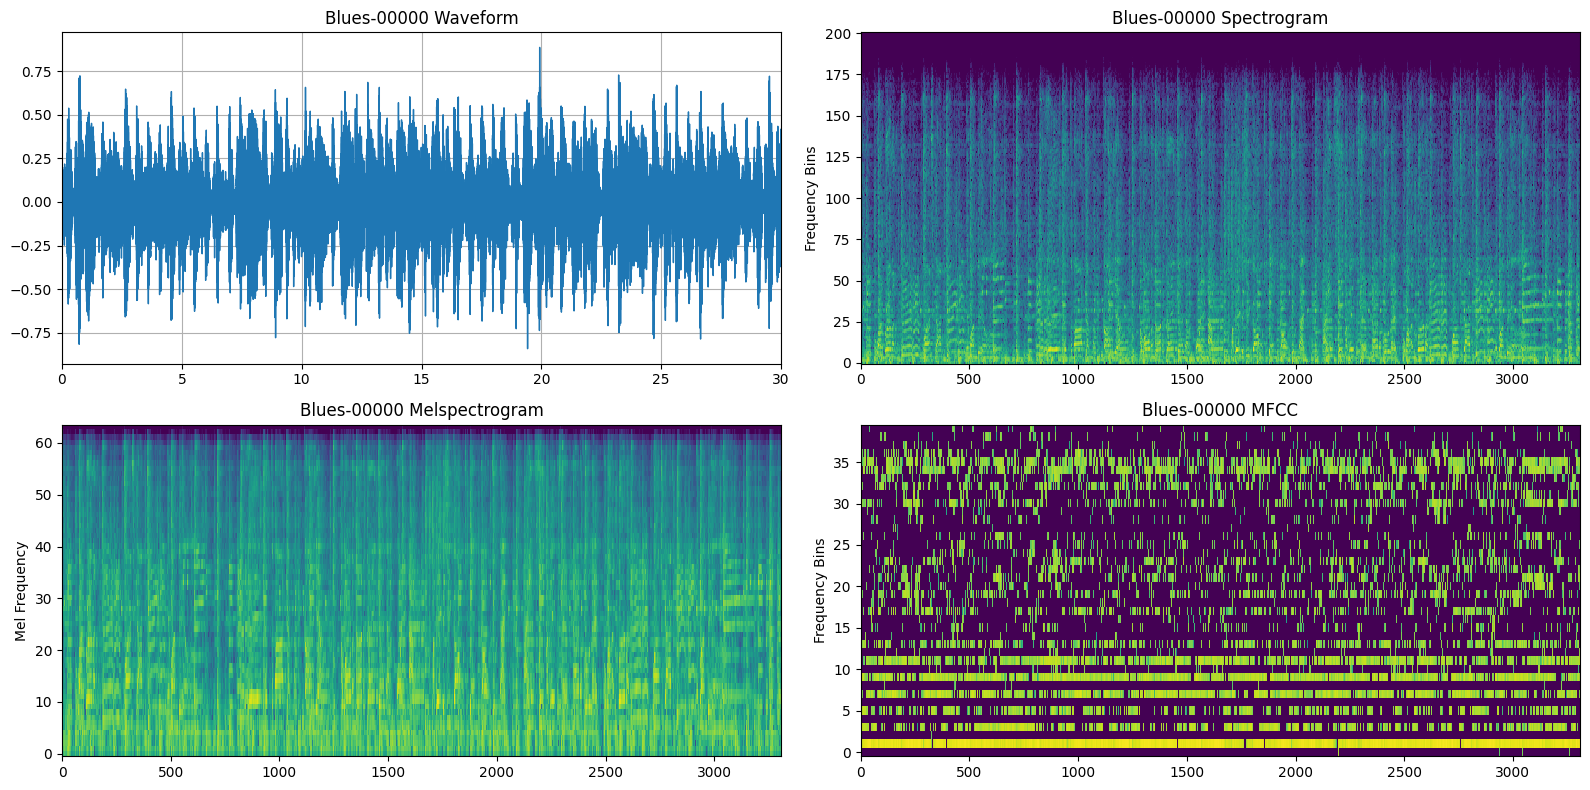

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
print_stats(audio_dataset[0])
plot_waveform(audio_dataset[0], title="Blues-00000 Waveform", ax=axs[0,0])
plot_spectrogram(audio_dataset[0], title="Blues-00000 Spectrogram", ax=axs[0,1])
plot_spectrogram(audio_dataset[0],  type="melspectrogram", title="Blues-00000 Melspectrogram",ax=axs[1,0])
plot_spectrogram(audio_dataset[0],  type="mfcc", title="Blues-00000 MFCC",ax=axs[1,1])
fig.tight_layout()

In [23]:
def random_feature_display(feature: str, suptitle: str, num_display_per_class: int = 5):
  fig, axs = plt.subplots(nrows=num_classes, ncols=num_display_per_class, figsize=(32/5 * num_display_per_class, 32))
  for cdx, class_label in enumerate(class_labels):
    for idx in range(num_display_per_class):
      selected_ax = axs[cdx,idx] if num_display_per_class != 1 else axs[cdx]
      select_idx = np.random.randint(0, 100)
      if feature == "waveplot":
        plot_waveform(audio_dataset[cdx * 100 + select_idx], ax=selected_ax)
      else:
        plot_spectrogram(audio_dataset[cdx * 100 + select_idx], type=feature, ax=selected_ax)
      selected_ax.set_title(f"{class_label}.{str(select_idx).zfill(5)}.wav")
  fig.suptitle(suptitle, y=1.0)
  fig.tight_layout()
  plt.show()

In [9]:
# Melspectrogram
random_feature_display("melspectrogram", "Mel Spectrogram")

Output hidden; open in https://colab.research.google.com to view.

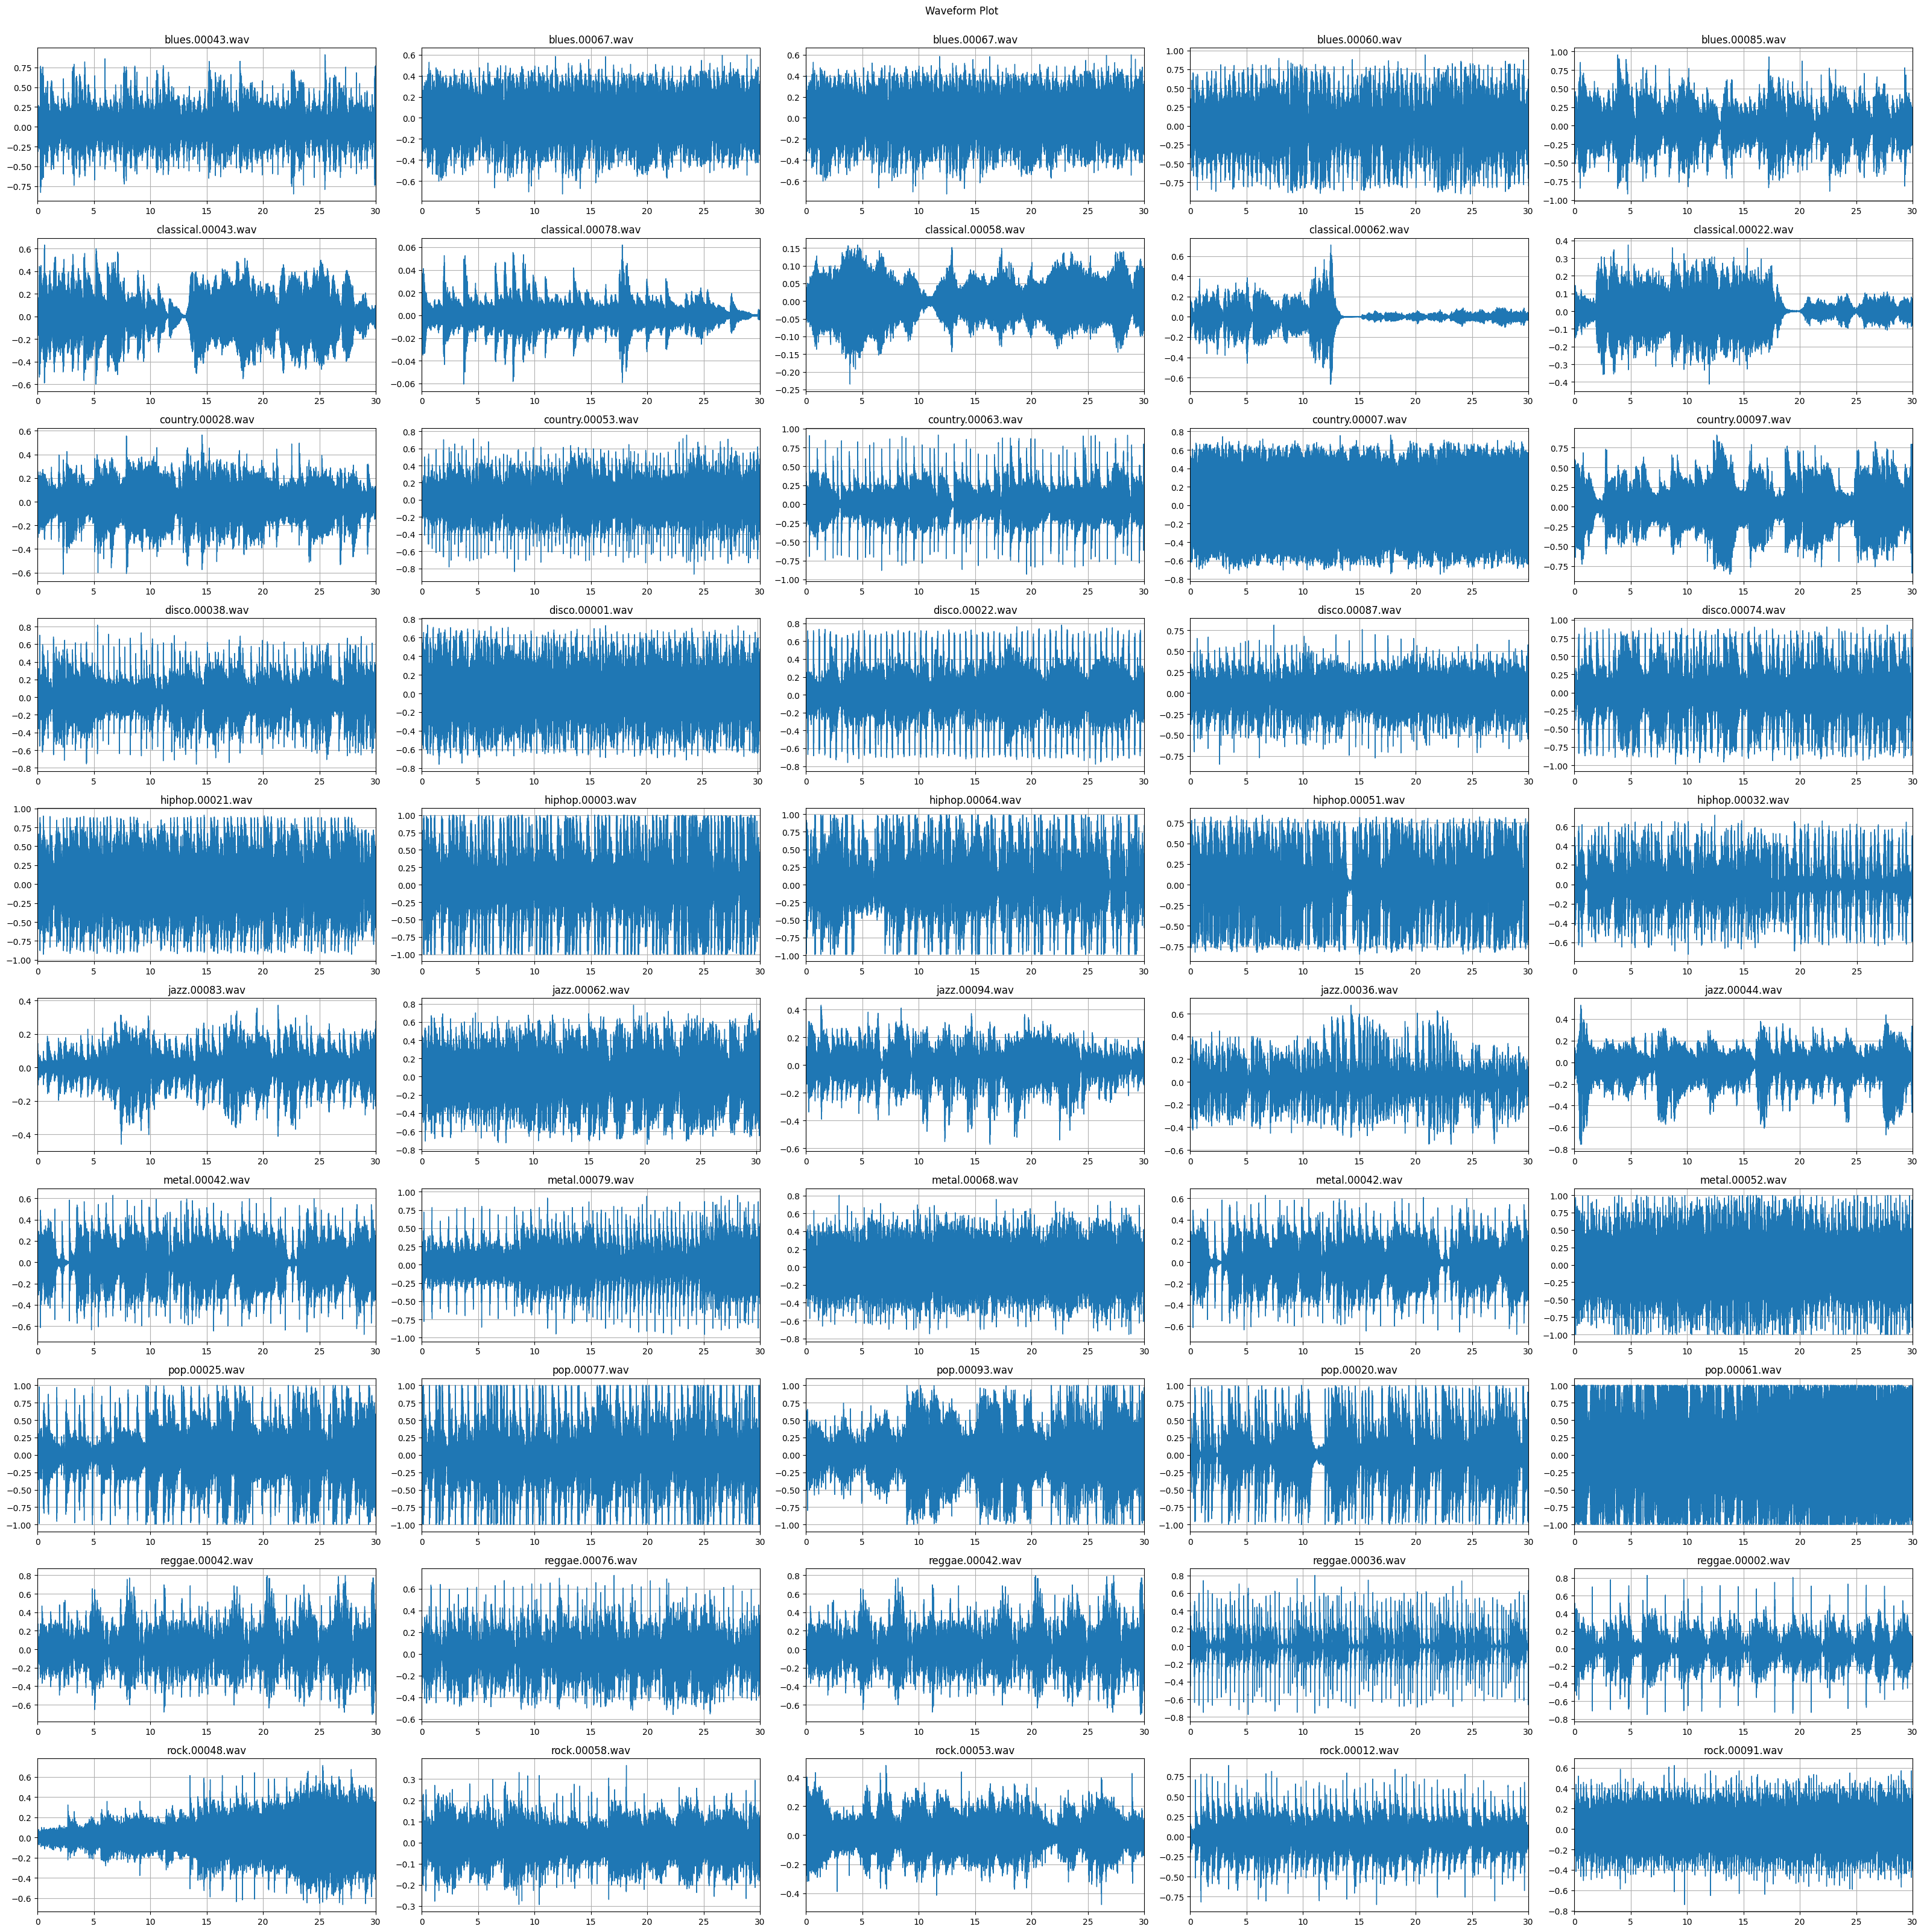

In [25]:
# Waveplot
random_feature_display("waveplot", "Waveform Plot")

In [11]:
# Spectrogram
random_feature_display("spectrogram", "Spectrogram")

Output hidden; open in https://colab.research.google.com to view.

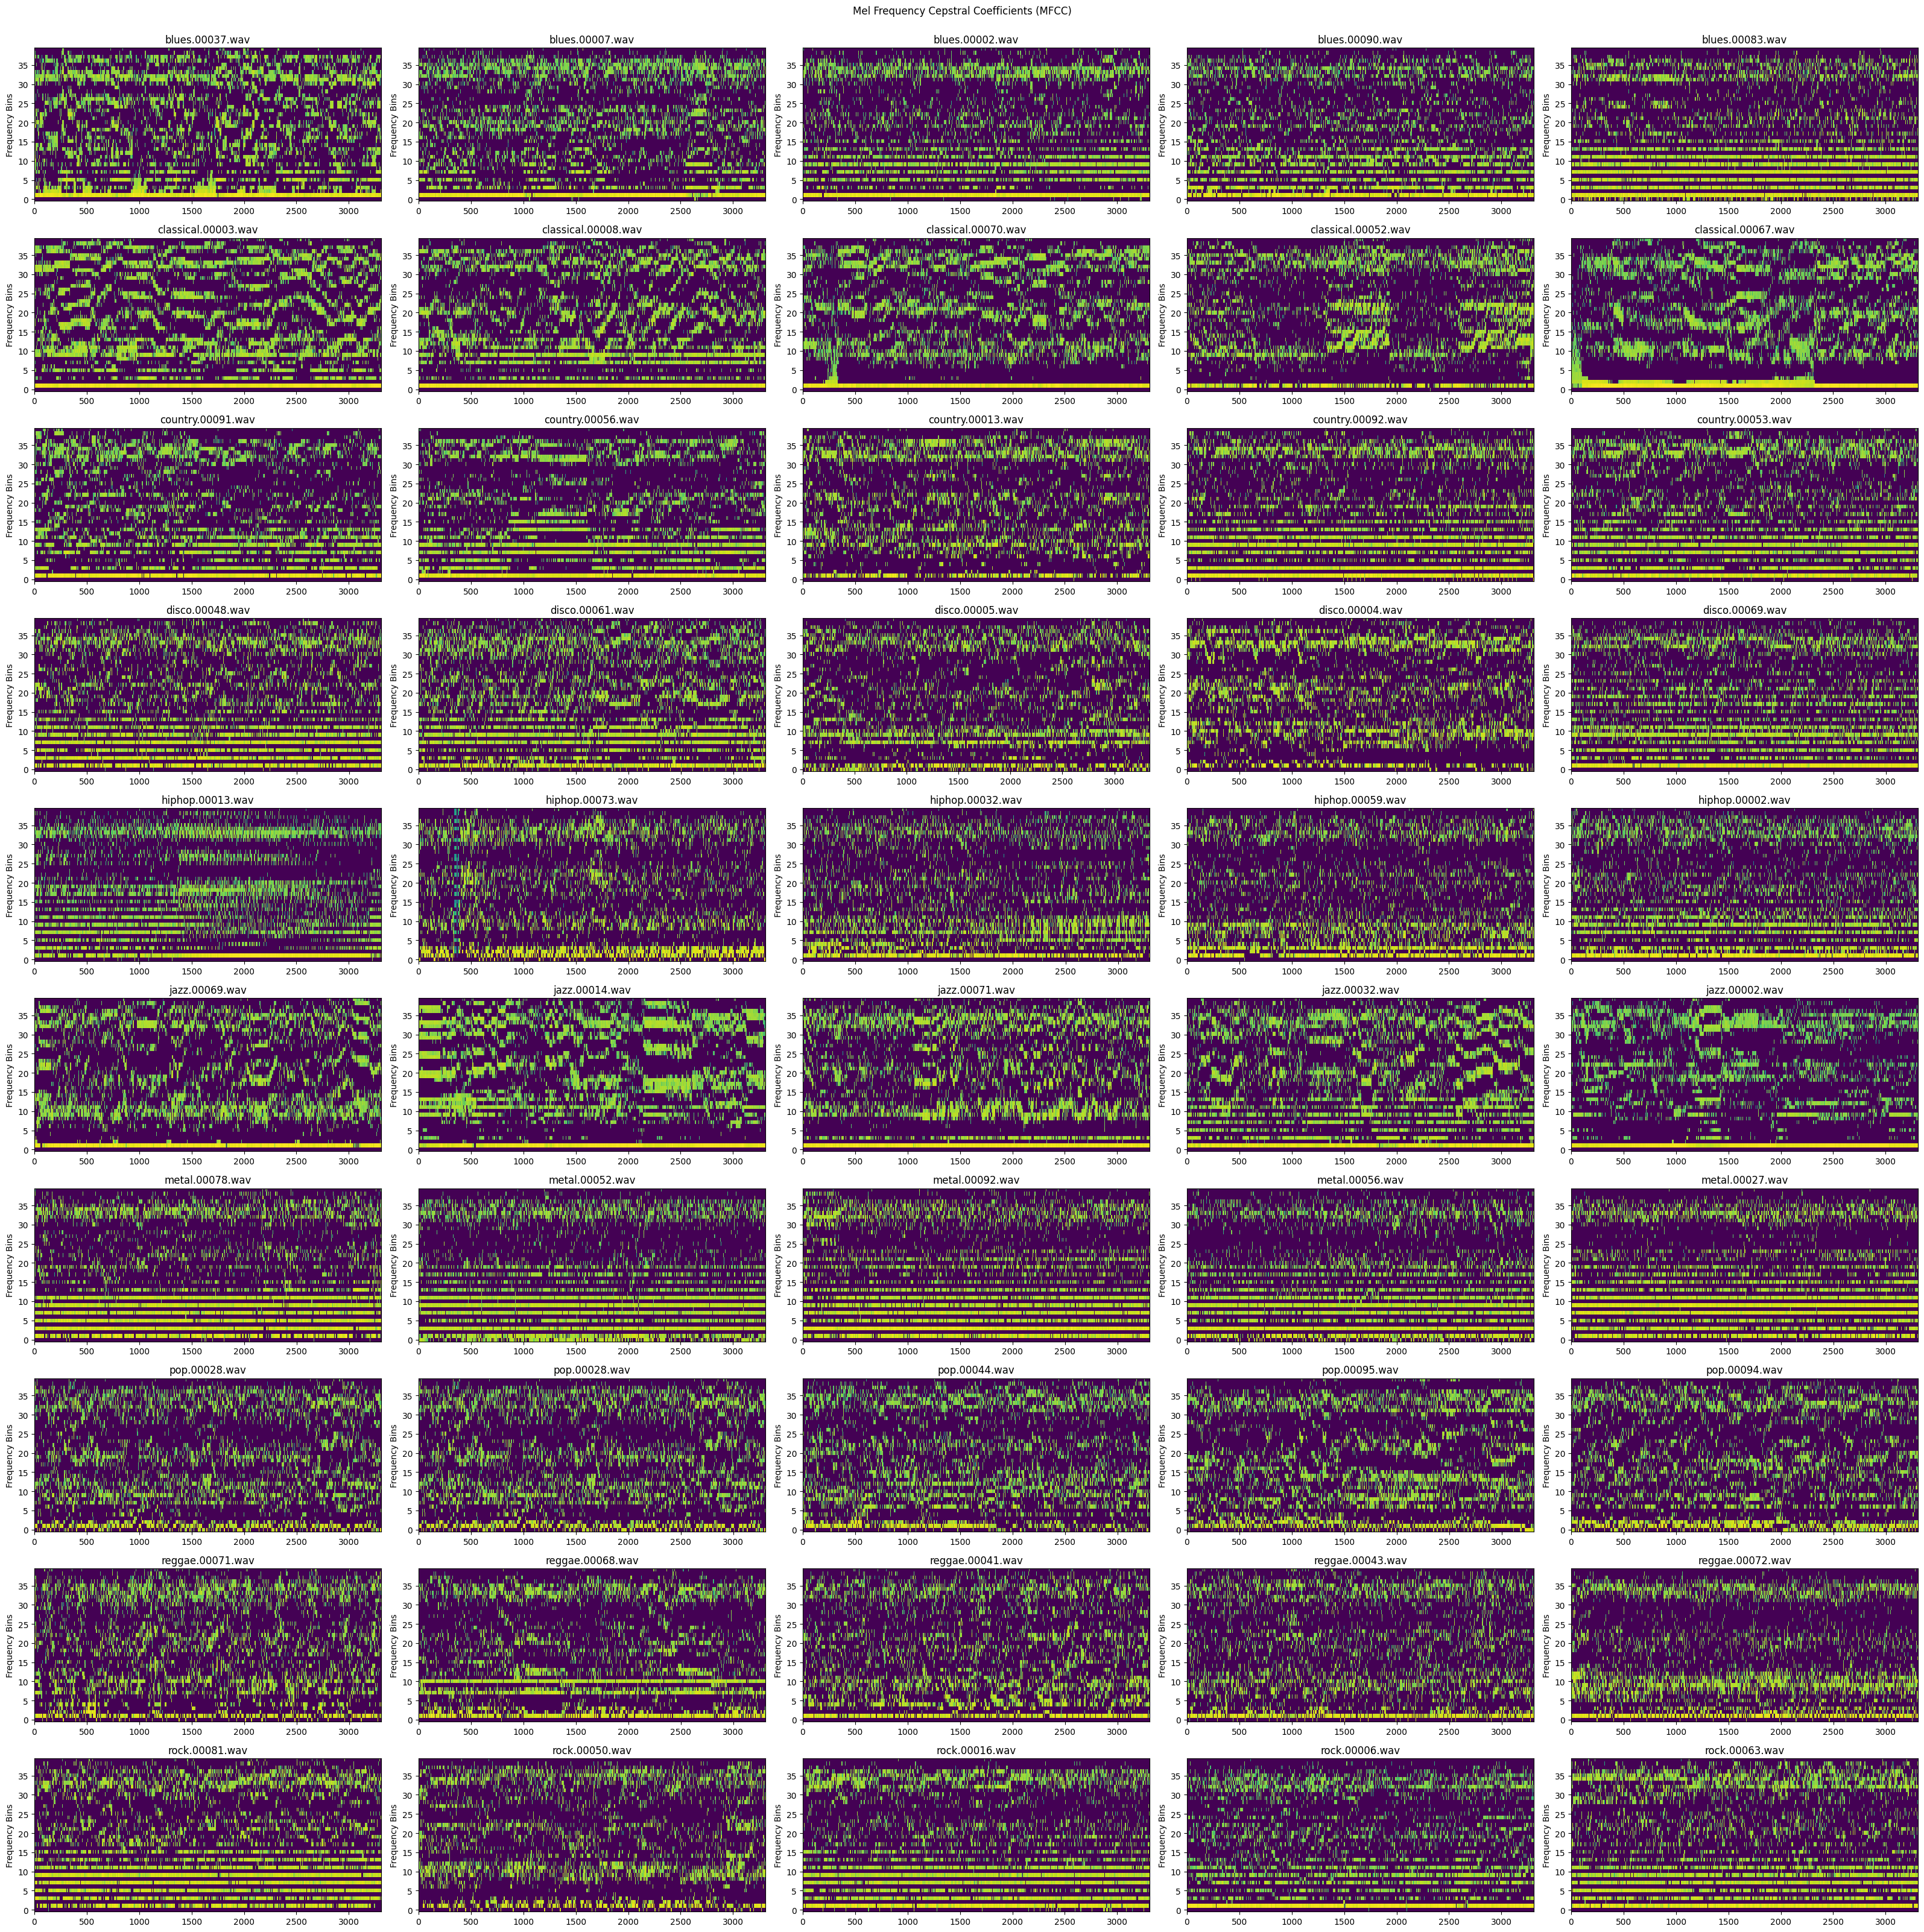

In [13]:
# MFCC
random_feature_display("mfcc", "Mel Frequency Cepstral Coefficients (MFCC)")

In [60]:
class Conv_2D(nn.Module):
  def __init__(self, input_channels, output_channels, shape=3, pooling=(2, 2), dropout=0.1):
    super(Conv_2D, self).__init__()
    self.convolution = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
    self.batch_norm = nn.BatchNorm2d(output_channels)
    self.leaky_ReLU = nn.LeakyReLU()
    self.max_pool = nn.MaxPool2d(pooling)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.convolution(x)
    x = self.batch_norm(x)
    x = self.leaky_ReLU(x)
    x = self.max_pool(x)
    out = self.dropout(x)
    return out

In [61]:
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self, num_channels=16, sample_rate=22050, n_fft=1024, f_min=0.0, f_max=11025.0, num_mels=128, num_classes=10):
    super(ConvolutionalNeuralNetwork, self).__init__()
    self.melspec = T.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, f_min=f_min, f_max=f_max, n_mels=num_mels)
    self.amplitude_to_db = T.AmplitudeToDB()
    self.input_batch_norm = nn.BatchNorm2d(1)

    # convolutional layers
    self.layer1 = Conv_2D(1, num_channels, pooling=(2, 3))
    self.layer2 = Conv_2D(num_channels, num_channels, pooling=(3, 4))
    self.layer3 = Conv_2D(num_channels, num_channels * 2, pooling=(2, 5))
    self.layer4 = Conv_2D(num_channels * 2, num_channels * 2, pooling=(3, 3))
    self.layer5 = Conv_2D(num_channels * 2, num_channels * 4, pooling=(3, 4))

    # dense layers
    self.dense1 = nn.Linear(num_channels * 4, num_channels * 4)
    self.dense_bn = nn.BatchNorm1d(num_channels * 4)
    self.dense2 = nn.Linear(num_channels * 4, num_classes)
    self.dropout = nn.Dropout(0.5)
    self.relu = nn.ReLU()

  def forward(self, wav):
    # input Preprocessing
    out = self.melspec(wav)
    out = self.amplitude_to_db(out)

    # input batch normalization
    out = out.unsqueeze(1)
    out = self.input_batch_norm(out)

    # convolutional layers
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)

    # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
    out = out.reshape(len(out), -1)

    # dense layers
    out = self.dense1(out)
    out = self.dense_bn(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.dense2(out)

    return out

In [62]:
class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.genres = class_labels
        self._get_song_list()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = np.random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]
        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, split='train', num_samples=22050 * 29, num_chunks=1, batch_size=16, num_workers=0):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, split, num_samples, num_chunks), batch_size=batch_size, shuffle=is_shuffle, drop_last=False, num_workers=num_workers)
    return data_loader

In [63]:
train_loader = get_dataloader(data_path="datasets/", split='train')
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

valid_loader = get_dataloader(data_path="datasets/", split='valid')
test_loader = get_dataloader(data_path="datasets/", split='test')
iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav.shape))
print('validation/test data shape: %s' % str(test_wav.shape))
print(train_genre)

training data shape: torch.Size([16, 639450])
validation/test data shape: torch.Size([16, 1, 639450])
tensor([0, 6, 9, 7, 1, 0, 6, 3, 9, 0, 3, 0, 7, 1, 0, 9])


In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = ConvolutionalNeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
valid_losses = []
num_epochs = 30

for epoch in range(num_epochs):
    losses = []

    # Train
    cnn.train()
    for (wav, genre_index) in train_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # Forward
        out = cnn(wav)
        loss = loss_function(out, genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    cnn.eval()
    y_true = []
    y_pred = []
    losses = []
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        loss = loss_function(logits, genre_index)
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), 'best_model.ckpt')

Epoch: [1/30], Train loss: 2.2852
Epoch: [1/30], Valid loss: 2.3037, Valid accuracy: 0.2030
Saving the best model at 0 epochs!
Epoch: [2/30], Train loss: 2.1227
Epoch: [2/30], Valid loss: 2.1567, Valid accuracy: 0.2234
Saving the best model at 1 epochs!
Epoch: [3/30], Train loss: 1.9797
Epoch: [3/30], Valid loss: 2.1019, Valid accuracy: 0.2335
Saving the best model at 2 epochs!
Epoch: [4/30], Train loss: 1.8625
Epoch: [4/30], Valid loss: 2.0601, Valid accuracy: 0.2386
Saving the best model at 3 epochs!
Epoch: [5/30], Train loss: 1.7502
Epoch: [5/30], Valid loss: 1.8843, Valid accuracy: 0.3401
Saving the best model at 4 epochs!
Epoch: [6/30], Train loss: 1.6595
Epoch: [6/30], Valid loss: 1.8578, Valid accuracy: 0.3096
Saving the best model at 5 epochs!
Epoch: [7/30], Train loss: 1.5360
Epoch: [7/30], Valid loss: 1.7856, Valid accuracy: 0.2944
Saving the best model at 6 epochs!
Epoch: [8/30], Train loss: 1.4422
Epoch: [8/30], Valid loss: 1.8288, Valid accuracy: 0.3553
Epoch: [9/30], Trai

In [65]:
# Load the best model
S = torch.load('best_model.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

loaded!


Accuracy: 0.4931


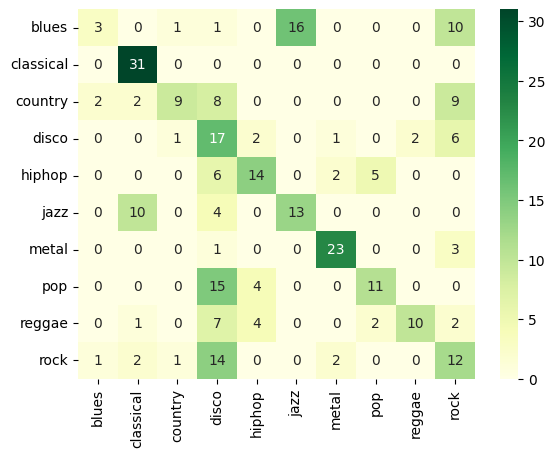

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap="YlGn")
print('Accuracy: %.4f' % accuracy)

In [80]:
print(cnn)
wav, _ = next(iter(train_loader))
wav = wav.to(device)
yhat = cnn(wav)
make_dot(yhat, params=dict(list(cnn.named_parameters()))).render("CNN_Model_GTZAN", format="png")

ConvolutionalNeuralNetwork(
  (melspec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (amplitude_to_db): AmplitudeToDB()
  (input_batch_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv_2D(
    (convolution): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_ReLU): LeakyReLU(negative_slope=0.01)
    (max_pool): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layer2): Conv_2D(
    (convolution): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leaky_ReLU): LeakyReLU(negative_slope=0.01)
    (max_pool): MaxPool2d(kernel_size=(3, 4), stride=(3, 4), padding=0, dilation=1, c

'CNN_Model_GTZAN.png'